In [30]:
import os
from dotenv import load_dotenv
from pyprojroot import here

load_dotenv()

True

In [31]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")


In [32]:
from langchain_core.tools import tool
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

EMBEDDING_MODEL = "text-embedding-3-small"
VECTORDB_DIR = "data\document_vectordb"


@tool
def lookup_documnet(query: str)->str:
    """Search within the given document to check whether certain options are permitted. Input should be a search query."""
    vectordb = Chroma(
        collection_name="rag-chroma",
        persist_directory=str(here(VECTORDB_DIR)),
        embedding_function=OpenAIEmbeddings(model=EMBEDDING_MODEL)
    )
    
    docs = vectordb.similarity_search(query, k=2)
    return "\n\n".join([doc.page_content for doc in docs])

In [33]:
print(lookup_documnet.name)
print(lookup_documnet.args)
print(lookup_documnet.description)

lookup_documnet
{'query': {'title': 'Query', 'type': 'string'}}
Search within the given document to check whether certain options are permitted. Input should be a search query.


In [34]:
lookup_documnet.invoke("can you describe me what is Amarok the lone wolf in 30 words?")

"Amarok the lone wolf \nIn the shadowed embrace of the Alaskan mountains, where the snow blankets the earth in a pristine \nwhite and the northern lights dance across the sky like ethereal spirits, there lived a lone wolf named \nAmarok. His coat was a tapestry of silver and midnight, a reflection of the landscape he called home. \nAmarok was a creature of solitude, but his heart ached with the memory of the family he had lost to the \nunforgiving wilderness. \nAmarok's journey began on a day when the sky wept snowflakes as large as feathers, and the wind \nwhispered secrets only the mountains could understand. He had been separated from his pack during a \nfierce winter storm that had descended upon them like a ravenous beast. The pack had been everything \nto Amarok: his community, his support, his family. Now, he roamed the vast expanse of the Alaskan \nrange, driven by a deep longing to find them. \nEach day was a testament to his resilience. Amarok traversed steep cliffs that claw

In [35]:
from langchain_community.tools.tavily_search import TavilySearchResults
search_tool = TavilySearchResults(max_results=2)

In [36]:
search_tool.invoke("What's a 'node' in LangGraph?")


[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog.langchain

In [37]:
print(search_tool.description)

A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.


In [38]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities import SQLDatabase
from langchain.agents import create_sql_agent
from langchain_community.utilities import SQLDatabase

class SQLAgentTool:
    """
    A tool for interacting with a travel-related SQL database using an LLM (Language Model) to generate and execute SQL queries.

    This tool enables users to ask travel-related questions, which are transformed into SQL queries by a language model.
    The SQL queries are executed on the provided SQLite database, and the results are processed by the language model to
    generate a final answer for the user.

    Attributes:
        sql_agent_llm (ChatOpenAI): An instance of a ChatOpenAI language model used to generate and process SQL queries.
        system_role (str): A system prompt template that guides the language model in answering user questions based on SQL query results.
        db (SQLDatabase): An instance of the SQL database used to execute queries.
        chain (RunnablePassthrough): A chain of operations that creates SQL queries, executes them, and generates a response.

    Methods:
        __init__: Initializes the TravelSQLAgentTool by setting up the language model, SQL database, and query-answering pipeline.
    """

    def __init__(self, llm: str, sqldb_directory: str, llm_temerature: float) -> None:
        """
        Initializes the TravelSQLAgentTool with the necessary configurations.

        Args:
            llm (str): The name of the language model to be used for generating and interpreting SQL queries.
            sqldb_directory (str): The directory path where the SQLite database is stored.
            llm_temerature (float): The temperature setting for the language model, controlling response randomness.
        """
        self.sql_agent_llm = ChatOpenAI(
            model=llm, temperature=llm_temerature)
        # self.system_role = """Given the following user question, corresponding SQL query, and SQL result, answer the user question.\n
        #     Question: {question}\n
        #     SQL Query: {query}\n
        #     SQL Result: {result}\n
        #     Answer:
        #     """
        self.db = SQLDatabase.from_uri(f"sqlite:///{sqldb_directory}")
        print(self.db.get_usable_table_names())

        print("table name printed")

        self.chain=create_sql_agent(llm=self.sql_agent_llm , db=self.db ,agent_executor_kwargs={
            "handle_parsing_errors": True
        })

        # execute_query = QuerySQLDataBaseTool(db=self.db)
        # write_query = create_sql_query_chain(
        #     self.sql_agent_llm, self.db)
        # answer_prompt = PromptTemplate.from_template(
        #     self.system_role)

        # answer = answer_prompt | self.sql_agent_llm | StrOutputParser()
        # self.chain = (
        #     RunnablePassthrough.assign(query=write_query).assign(
        #         result=itemgetter("query") | execute_query
        #     )
        #     | answer
        # )

from langchain_core.tools import tool
llm_model="gpt-4o-mini"
sqldb_directory_path="BIRD (1).db"
llm_temerature_arg=0.0


@tool
def query_sqldb(query: str) -> str:
    """Query SQL Database and access all the information. Input should be a search query."""
    agent = SQLAgentTool(
        llm="gpt-4o-mini",
        sqldb_directory="BIRD (1).db",
        llm_temerature=0.2
    )
    # response = agent.chain.run({"question": query})
    response = agent.chain.run(query)

    return response

In [39]:
print(query_sqldb.args)
print(query_sqldb.description)

{'query': {'title': 'Query', 'type': 'string'}}
Query SQL Database and access all the information. Input should be a search query.


In [40]:
tools=[search_tool,lookup_documnet,query_sqldb]

In [41]:
llm=ChatOpenAI(model="gpt-4o-mini" ,temperature=0.5)
llm_with_tools=llm.bind_tools(tools)

In [42]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [43]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot",chatbot)

In [44]:
input={"messages":[llm_with_tools.invoke("What's a 'node' in LangGraph?")]}

In [45]:
print(input)
msg=input.get("messages",[])[-1]
print(msg)
tool_call=msg.tool_calls
print(tool_call[-1])
print(tool_call[-1]["name"])
print(tool_call[-1]["args"])

tools_by_name={tool.name:tool for tool in tools}
print(tools_by_name)
type(tools_by_name)

tool_result=tools_by_name[tool_call[-1]["name"]].invoke(tool_call[-1]["args"])
print(tool_result)

import json
from langchain_core.messages import ToolMessage

output=[]
print(tool_result)
print(json.dumps(tool_result))
print(tool_call[-1]["name"])
print(tool_call[-1]["id"])
output.append(ToolMessage(
    content=json.dumps(tool_result),
    name=tool_call[-1]["name"],
    tool_call_id=tool_call[-1]["id"],
                )
)
print(output)
print({"message":output})


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_y99x5O8EAX38KjivTzNt50O2', 'function': {'arguments': '{"query":"node in LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 155, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ccdd8d33-cd4e-4da0-ad42-8ef71b5f5b1b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'node in LangGraph'}, 'id': 'call_y99x5O8EAX38KjivTzNt50O2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 155, 'output_tokens': 22, 'total_tokens': 177, 'input_token_details': {'audio': 

In [46]:
import json
from langchain_core.messages import ToolMessage


# class BasicToolNode:
#     """A node that runs the tools requested in the last AIMessage."""

#     def __init__(self, tools: list) -> None:
#         self.tools_by_name = {tool.name: tool for tool in tools}

#     def __call__(self, inputs: dict):
#         if messages := inputs.get("messages", []):
#             message = messages[-1]
#         else:
#             raise ValueError("No message found in input")
#         outputs = []
#         for tool_call in message.tool_calls:
#             tool_result = self.tools_by_name[tool_call[-1]["name"]].invoke(
#                 tool_call[-1]["args"]
#             )
#             outputs.append(
#                 ToolMessage(
#                     content=json.dumps(tool_result),
#                     name=tool_call[-1]["name"],
#                     tool_call_id=tool_call[-1]["id"],
#                 )
#             )
#         return {"messages": outputs}


# tool_node = BasicToolNode(tools=[search_tool,lookup_documnet,query_sqldb])
# graph_builder.add_node("tools", tool_node)

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[search_tool,lookup_documnet,query_sqldb])
graph_builder.add_node("tools", tool_node)

In [47]:
ai_message=input.get("messages",[])[-1]
print(ai_message)
print(ai_message.tool_calls)


content='' additional_kwargs={'tool_calls': [{'id': 'call_y99x5O8EAX38KjivTzNt50O2', 'function': {'arguments': '{"query":"node in LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 155, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-ccdd8d33-cd4e-4da0-ad42-8ef71b5f5b1b-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'node in LangGraph'}, 'id': 'call_y99x5O8EAX38KjivTzNt50O2', 'type': 'tool_call'}] usage_metadata={'input_tokens': 155, 'output_tokens': 22, 'total_tokens': 177, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_

In [48]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [49]:
# from langgraph.checkpoint.memory import MemorySaver

# memory = MemorySaver()
# graph = graph_builder.compile(checkpointer=memory)
graph=graph_builder.compile()

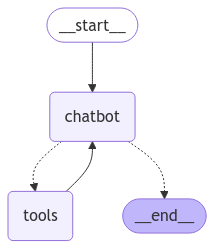

In [50]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [51]:
# config = {"configurable": {"thread_id": "1"}}

In [52]:
# user_input = "what is the node in langgraph?"

# # The config is the **second positional argument** to stream() or invoke()!
# events = graph.stream(
#     {"messages": [("user", user_input)]}, config, stream_mode="values"
# )
# for event in events:
#     event["messages"][-1].pretty_print()

user_input = "what is the node in langgraph?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is the node in langgraph?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Rmy0S8KdTeCJDp2IU77G1M1i)
 Call ID: call_Rmy0S8KdTeCJDp2IU77G1M1i
  Args:
    query: node in langgraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48", "content": "Beginner\u2019s Guide to LangGraph: Understanding State, Nodes, and Edges \u2014 Part 1 | by Kamal Dhungana | Medium Beginner\u2019s Guide to LangGraph: Understanding State, Nodes, and Edges \u2014 Part 1 LangGraph \u2014 State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we und

In [53]:
event

{'messages': [HumanMessage(content='what is the node in langgraph?', additional_kwargs={}, response_metadata={}, id='482c3d9d-d87f-48dd-99b8-6b3ae24c6b25'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Rmy0S8KdTeCJDp2IU77G1M1i', 'function': {'arguments': '{"query":"node in langgraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 154, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ef0d0ac1-aecb-4ea9-b7e6-a9fabcc6dc05-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'node in langgraph'}, 'id': 'call_Rmy0S8KdTeCJDp2IU

In [54]:
user_input = "give me the employee name with the highest salary"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the employee name with the highest salary
================================== Ai Message ==================================
Tool Calls:
  query_sqldb (call_UoX0OqmkOdZNgfWsps9CSPnj)
 Call ID: call_UoX0OqmkOdZNgfWsps9CSPnj
  Args:
    query: SELECT name FROM employees ORDER BY salary DESC LIMIT 1;
['Billing', 'ChangeOrder', 'ComplianceIssue', 'Contract', 'CostCodes', 'Employee', 'Expense', 'Invoice', 'Projects', 'Revenue', 'SubContract', 'Task', 'Time_Tracking']
table name printed
================================= Tool Message =================================
Name: query_sqldb

"The employee with the highest hourly rate is Ian Garcia."
================================== Ai Message ==================================

The employee with the highest salary is Ian Garcia.


In [55]:
user_input = "can you describe me what is Amarok the lone wolf in 15 words?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you describe me what is Amarok the lone wolf in 15 words?
================================== Ai Message ==================================

Amarok, the lone wolf, is a mythical creature symbolizing strength, independence, and wilderness spirit.


In [56]:
user_input = "give me the top 5 employee id with highest salary"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the top 5 employee id with highest salary
================================== Ai Message ==================================
Tool Calls:
  query_sqldb (call_BbxZJED35g9RtSXZz70d3enw)
 Call ID: call_BbxZJED35g9RtSXZz70d3enw
  Args:
    query: SELECT employee_id, salary FROM employees ORDER BY salary DESC LIMIT 5;
['Billing', 'ChangeOrder', 'ComplianceIssue', 'Contract', 'CostCodes', 'Employee', 'Expense', 'Invoice', 'Projects', 'Revenue', 'SubContract', 'Task', 'Time_Tracking']
table name printed
================================= Tool Message =================================
Name: query_sqldb

"The top 5 employees by hourly rate are: (19, 67.81), (105, 67.81), (141, 67.81), (182, 67.81), (20, 59.14)."
================================== Ai Message ==================================

The top 5 employee IDs with the highest salaries are:

1. Employee ID: 19, Salary: $67.81
2. Employee ID: 105, Salary: 

In [ ]:
from langchain_core.messages import HumanMessage,AIMessage

event={'messages': [HumanMessage(content='what is the node in langgraph?', additional_kwargs={}, response_metadata={}, id='dc891d2b-e0ce-4c45-b09e-a212ad5b6281'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0rvB5c85K8RQBNVPm4iVWaQ7', 'function': {'arguments': '{"query":"node in langgraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 154, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f2af3daf-c6c8-4f41-9f26-b1fc727e5fe9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'node in langgraph'}, 'id': 'call_0rvB5c85K8RQBNVPm4iVWaQ7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 154, 'output_tokens': 22, 'total_tokens': 176, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='what is the node in langgraph?', additional_kwargs={}, response_metadata={}, id='1c4e28d1-54dc-4ec4-a70a-afa6fd5d0bb0'), HumanMessage(content='what is the node in langgraph?.', additional_kwargs={}, response_metadata={}, id='fa0d6f02-a065-460a-8700-7399f62bfb09'), HumanMessage(content='what is the node in langgraph?.', additional_kwargs={}, response_metadata={}, id='760a2e7d-8db3-490e-91bc-f33f42d3aa48')]}
print(event)
print(event["messages"])
print(event["messages"][-1])
print(event["messages"][-1].pretty_print())

In [ ]:
for event in events:
    print(event)

In [183]:
event

{'messages': [HumanMessage(content='give me the top 5 employee id with highest salary', additional_kwargs={}, response_metadata={}, id='d2687f36-0f09-4b77-a815-de4505eb6c49'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cxBAtH6Dnt0A0jLNczyOq6Lb', 'function': {'arguments': '{"query":"SELECT employee_id, salary FROM employees ORDER BY salary DESC LIMIT 5;"}', 'name': 'query_sqldb'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 157, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-752a4194-ca55-4ce6-8c14-7b322451389d-0', tool_calls=[{'name': 'query_sqldb', 'args': {'query': 'SELECT 